In [1]:
import tensorflow as tf
from tensorflow.keras import Model
from tensorflow.keras import layers
import foolbox as fb
import eagerpy as ep
import matplotlib.pyplot as plt
import numpy as np

model = tf.keras.models.load_model('../saved-models/attack-test-model')

/Users/florianmerkle/dev/foolbox/foolbox/attacks/brendel_bethge.py:781: NumbaDeprecationWarning: The 'numba.jitclass' decorator has moved to 'numba.experimental.jitclass' to better reflect the experimental nature of the functionality. Please update your imports to accommodate this change and see http://numba.pydata.org/numba-doc/latest/reference/deprecation.html#change-of-jitclass-location for the time frame.
  @jitclass(spec=[])
/Users/florianmerkle/dev/foolbox/foolbox/attacks/brendel_bethge.py:1364: NumbaDeprecationWarning: The 'numba.jitclass' decorator has moved to 'numba.experimental.jitclass' to better reflect the experimental nature of the functionality. Please update your imports to accommodate this change and see http://numba.pydata.org/numba-doc/latest/reference/deprecation.html#change-of-jitclass-location for the time frame.
  @jitclass(spec=spec)
/Users/florianmerkle/dev/foolbox/foolbox/attacks/brendel_bethge.py:1560: NumbaDeprecationWarning: The 'numba.jitclass' decorator 

In [2]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()
x_train = (x_train.reshape(60000, 784).astype('float32') / 255)
x = tf.convert_to_tensor(tf.expand_dims(x_train[422].reshape(28,28,1), axis=0), tf.float32)*1
y = tf.convert_to_tensor([y_train[422]])*1

In [14]:
fmodel = fb.models.TensorFlowModel(model, bounds=(0,1))
attack = fb.attacks.L0BrendelBethgeAttack()

adversarials = attack(
    fmodel,
    x,
    y,
    epsilons=[28*28]
)
adversarials[2]

norms TensorFlowTensor(<tf.Tensor: shape=(1,), dtype=float32, numpy=array([499.], dtype=float32)>)
factor1 TensorFlowTensor(<tf.Tensor: shape=(1,), dtype=float32, numpy=array([1.5711423], dtype=float32)>)
perturbed TensorFlowTensor(<tf.Tensor: shape=(1, 28, 28, 1), dtype=float32, numpy=
                 array([[[[0.07044443],
                          [0.        ],
                          [0.        ],
                          [0.08457199],
                          [0.12587953],
                          [0.05293375],
                          [0.05382381],
                          [0.08535523],
                          [0.        ],
                          [0.0628047 ],
                          [0.10226729],
                          [0.        ],
                          [0.        ],
                          [0.        ],
                          [0.        ],
                          [0.        ],
                          [0.        ],
                          [0.111

<tf.Tensor: shape=(1, 1), dtype=bool, numpy=array([[ True]])>

In [12]:
diese = tf.convert_to_tensor(adversarials[0])
np.set_printoptions(suppress=True)
diese

<tf.Tensor: shape=(1, 1, 28, 28, 1), dtype=float32, numpy=
array([[[[[0.        ],
          [0.        ],
          [0.10590051],
          [0.06768072],
          [0.13216199],
          [0.08768141],
          [0.        ],
          [0.07722764],
          [0.06026253],
          [0.07030806],
          [0.        ],
          [0.11877762],
          [0.09507262],
          [0.1020853 ],
          [0.05910035],
          [0.04999703],
          [0.0580991 ],
          [0.        ],
          [0.09077349],
          [0.        ],
          [0.13850555],
          [0.        ],
          [0.10285173],
          [0.        ],
          [0.12503043],
          [0.        ],
          [0.13838181],
          [0.        ]],

         [[0.        ],
          [0.0564401 ],
          [0.        ],
          [0.        ],
          [0.07118921],
          [0.1314143 ],
          [0.        ],
          [0.08213422],
          [0.13822584],
          [0.0796352 ],
          [0.10897826],
   

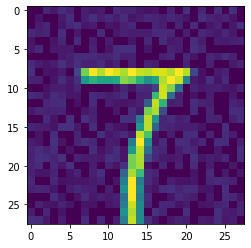

In [13]:
plt.figure()
plt.imshow(tf.reshape(diese, (28,28)))
plt.show()

In [6]:
tf.convert_to_tensor(adversarials[1]) - tf.convert_to_tensor(adversarials[0])

<tf.Tensor: shape=(1, 1, 28, 28, 1), dtype=float32, numpy=
array([[[[[0.],
          [0.],
          [0.],
          [0.],
          [0.],
          [0.],
          [0.],
          [0.],
          [0.],
          [0.],
          [0.],
          [0.],
          [0.],
          [0.],
          [0.],
          [0.],
          [0.],
          [0.],
          [0.],
          [0.],
          [0.],
          [0.],
          [0.],
          [0.],
          [0.],
          [0.],
          [0.],
          [0.]],

         [[0.],
          [0.],
          [0.],
          [0.],
          [0.],
          [0.],
          [0.],
          [0.],
          [0.],
          [0.],
          [0.],
          [0.],
          [0.],
          [0.],
          [0.],
          [0.],
          [0.],
          [0.],
          [0.],
          [0.],
          [0.],
          [0.],
          [0.],
          [0.],
          [0.],
          [0.],
          [0.],
          [0.]],

         [[0.],
          [0.],
         

'''


class CustomLayer(layers.Layer):

    def __init__(self, units=32, activation='relu', input_shape=(784)):
        super(CustomLayer, self).__init__()
        self.units = units
        self.activation = activation
        self.w = self.add_weight(shape=(input_shape[-1], self.units),
                                 initializer='random_normal',
                                 trainable=True,
                                 name='unpruned-weights')
        self.mask = self.add_weight(shape=(self.w.shape),
                                    initializer='ones',
                                    trainable=False,
                                   name='pruning-masks')
        self.pruned_w = self.add_weight(shape=(input_shape[-1], self.units),
                                 initializer='ones',
                                 trainable=False,
                                       name='pruned-weights')

   
    def call(self, inputs):
        self.pruned_w = tf.multiply(self.w, self.mask)
        x = tf.matmul(inputs, self.pruned_w)
        
        if self.activation == 'relu':
            return tf.keras.activations.relu(x)
        if self.activation == 'softmax':
            return tf.keras.activations.softmax(x)
        if self.activation == None:
            return x
            
        raise ValueError('Activation function not implemented')


class LeNet300_100(tf.keras.Model):
    def __init__(self):
        super(LeNet300_100, self).__init__()
        self.dense1 = CustomLayer(300, input_shape=(None, 784))
        self.dense2 = CustomLayer(100, input_shape=(None, 300))
        self.dense3 = CustomLayer(10, activation=None, input_shape=(None, 100))
        
    def call(self, inputs):
        x = tf.keras.layers.Flatten()(inputs)
        x = self.dense1(x)
        
        x = self.dense2(x)
        x = self.dense3(x)
        self.pre_softmax = x
        return tf.keras.activations.softmax(x)

def initialize_model():
    model = LeNet300_100()
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
                  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True) ,
                  metrics=['accuracy'],
                  experimental_run_tf_function=False
                 )
    return model

def train_model(model):
    callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)
    model.fit(x=x_train,
              y=y_train,
              batch_size=64,
              epochs=5,
              callbacks=[callback],
              validation_data=(x_test, y_test),
             )
    
model = initialize_model()
train_model(model)


#model = tf.keras.models.load_model('../saved-models/attack-test-model')


'''